# Chapter 7: Modeling Readiness

**Purpose:** Validate that data is ready for machine learning and identify potential pitfalls.

**What you'll learn:**
- How to assess if your data is ready for modeling
- How to detect potential data leakage before it ruins your model
- How to handle class imbalance in binary classification
- What preprocessing steps are needed before training

**Outputs:**
- Pre-modeling validation checklist with pass/fail status
- Detailed leakage risk assessment (including temporal leakage)
- Class imbalance analysis with strategy recommendations
- Overall readiness score

---

## Why Modeling Readiness Matters

| Issue | Impact | Detection |
|-------|--------|-----------|
| **Data Leakage** | Overly optimistic results that fail in production | High correlation with target, future information |
| **Class Imbalance** | Model ignores minority class | Ratio > 3:1 between classes |
| **Missing Values** | Model failures or bias | >50% missing in any column |
| **Insufficient Data** | Overfitting, poor generalization | <100 rows for simple models |

## 7.1 Setup

In [1]:
from customer_retention.analysis.auto_explorer import ExplorationFindings
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import ColumnType
from customer_retention.stages.modeling import ImbalanceRecommender, ImbalanceHandler, ImbalanceStrategy
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# === CONFIGURATION ===
from pathlib import Path

# FINDINGS_DIR imported from customer_retention.core.config.experiments

findings_files = [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name]
if not findings_files:
    raise FileNotFoundError(f"No findings files found in {FINDINGS_DIR}. Run notebook 01 first.")

# Prefer aggregated findings (from 01d) over event-level findings
# Pattern: *_aggregated* in filename indicates aggregated data
aggregated_files = [f for f in findings_files if "_aggregated" in f.name]
non_aggregated_files = [f for f in findings_files if "_aggregated" not in f.name]

if aggregated_files:
    # Use most recent aggregated file
    aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(aggregated_files[0])
    print(f"Found {len(aggregated_files)} aggregated findings file(s)")
    print(f"Using: {FINDINGS_PATH}")
    if non_aggregated_files:
        print(f"   (Skipping {len(non_aggregated_files)} event-level findings)")
else:
    # Fall back to most recent non-aggregated file
    non_aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(non_aggregated_files[0])
    print(f"Found {len(findings_files)} findings file(s)")
    print(f"Using: {FINDINGS_PATH}")

findings = ExplorationFindings.load(FINDINGS_PATH)

# Load data - handle aggregated vs standard paths
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS

# For aggregated data, load directly from the parquet source
if "_aggregated" in FINDINGS_PATH and findings.source_path.endswith('.parquet'):
    source_path = Path(findings.source_path)
    # Handle relative path from notebook directory
    if not source_path.is_absolute():
        # The source_path in findings is relative to project root
        if str(source_path).startswith("experiments"):
            source_path = Path("..") / source_path
        else:
            source_path = FINDINGS_DIR / source_path.name
    df = pd.read_parquet(source_path)
    data_source = f"aggregated:{source_path.name}"
else:
    # Standard loading for event-level or entity-level data
    df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))

charts = ChartBuilder()

print(f"\nLoaded {len(df):,} rows from: {data_source}")

Found 1 aggregated findings file(s)
Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml
   (Skipping 1 event-level findings)



Loaded 4,998 rows from: aggregated:customer_emails_408768_aggregated.parquet


## 7.2 Modeling Readiness Checklist

In [3]:
checklist = []

has_target = findings.target_column is not None
checklist.append({"Check": "Target column identified", "Status": "Pass" if has_target else "Fail"})

has_features = len([c for c in findings.columns.values() 
                   if c.inferred_type not in [ColumnType.IDENTIFIER, ColumnType.TARGET]]) > 0
checklist.append({"Check": "Feature columns available", "Status": "Pass" if has_features else "Fail"})

high_missing = any(c.universal_metrics.get("null_percentage", 0) > 50 
                   for c in findings.columns.values())
checklist.append({"Check": "No columns with >50% missing", "Status": "Fail" if high_missing else "Pass"})

good_quality = findings.overall_quality_score >= 70
checklist.append({"Check": "Quality score >= 70", "Status": "Pass" if good_quality else "Warn"})

sufficient_rows = findings.row_count >= 100
checklist.append({"Check": "Sufficient sample size (>=100)", "Status": "Pass" if sufficient_rows else "Fail"})

print("Modeling Readiness Checklist:")
print("="*50)
checklist_df = pd.DataFrame(checklist)
display(checklist_df)

Modeling Readiness Checklist:


,Check,Status
0,Target column identified,Pass
1,Feature columns available,Pass
2,No columns with >50% missing,Fail
3,Quality score >= 70,Pass
4,Sufficient sample size (>=100),Pass


## 7.3 Class Imbalance Analysis

**📖 Understanding Class Imbalance:**
- **Ratio < 3:1** - Mild imbalance, standard methods work
- **Ratio 3:1 to 10:1** - Moderate imbalance, use stratified sampling + class weights
- **Ratio > 10:1** - Severe imbalance, consider SMOTE, undersampling, or focal loss

**⚠️ Why It Matters:**
- Imbalanced data causes models to predict the majority class
- Accuracy is misleading (80% accuracy when 80% is majority = useless model)
- Use F1-score, Precision, Recall, and AUC instead of accuracy

CLASS IMBALANCE ANALYSIS

Target Column: target
Target Type: binary
Missing Values: 0

📊 CLASS DISTRIBUTION:
  Majority Class (0): 3,034 (60.7%)
  Minority Class (1): 1,964 (39.3%)

🟢 Class Imbalance: LOW (1.5:1)

Ratio 1.5:1 is manageable. Class weights are usually sufficient.

Recommended strategies (in order of preference):
  → 1. class_weight: Adjust loss function weights (no data modification)


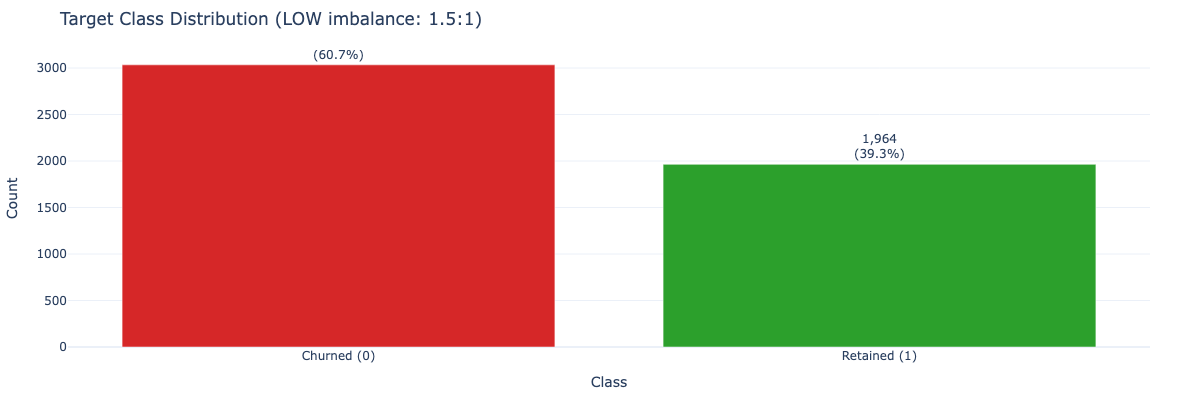


💡 SKLEARN CLASS WEIGHTS:
  class_weight={0: 0.824, 1: 1.272}
  Or use class_weight='balanced'


In [4]:
if findings.target_column:
    target = findings.target_column
    target_series = df[target]
    
    print("=" * 70)
    print("CLASS IMBALANCE ANALYSIS")
    print("=" * 70)
    
    print(f"\nTarget Column: {target}")
    print(f"Target Type: {findings.target_type}")
    print(f"Missing Values: {target_series.isnull().sum()}")
    
    if findings.target_type == "binary":
        value_counts = target_series.value_counts()
        majority_class = value_counts.idxmax()
        minority_class = value_counts.idxmin()
        majority_count = value_counts.max()
        minority_count = value_counts.min()
        
        print(f"\n📊 CLASS DISTRIBUTION:")
        print(f"  Majority Class ({majority_class}): {majority_count:,} ({majority_count/len(df)*100:.1f}%)")
        print(f"  Minority Class ({minority_class}): {minority_count:,} ({minority_count/len(df)*100:.1f}%)")
        
        # Use framework recommender for strategy recommendations
        recommender = ImbalanceRecommender()
        rec = recommender.recommend(target_series, n_samples=len(df))
        rec.print_recommendation()
        
        # Visualize
        severity_colors = {"low": "#2ca02c", "moderate": "#ffbb00", "high": "#ff7f0e", "severe": "#d62728"}
        fig = go.Figure(go.Bar(
            x=['Churned (0)', 'Retained (1)'],
            y=[value_counts.get(0, 0), value_counts.get(1, 0)],
            marker_color=['#d62728', '#2ca02c'],
            text=[f'{value_counts.get(0, 0):,}<br>({value_counts.get(0, 0)/len(df)*100:.1f}%)',
                  f'{value_counts.get(1, 0):,}<br>({value_counts.get(1, 0)/len(df)*100:.1f}%)'],
            textposition='outside'
        ))
        fig.update_layout(
            title=f'Target Class Distribution ({rec.severity.upper()} imbalance: {rec.ratio:.1f}:1)',
            xaxis_title='Class', yaxis_title='Count',
            template='plotly_white', height=400
        )
        display_figure(fig)
        
        # Show sklearn class weights
        print(f"\n💡 SKLEARN CLASS WEIGHTS:")
        weight_minority = len(df) / (2 * minority_count)
        weight_majority = len(df) / (2 * majority_count)
        print(f"  class_weight={{0: {weight_majority:.3f}, 1: {weight_minority:.3f}}}")
        print(f"  Or use class_weight='balanced'")
        
        # Store recommendation for later use
        imbalance_recommendation = rec
else:
    print("ERROR: No target column identified. Please set one in findings.")

## 7.4 Data Leakage Risk Assessment

**📖 Types of Leakage:**
- **Target Leakage**: Feature contains information about the target that wouldn't be available at prediction time
- **Train-Test Leakage**: Information from test set leaks into training (e.g., scaling before split)
- **Temporal Leakage**: Using future information to predict past events

**⚠️ Warning Signs:**
- Correlation > 0.9 with target (suspiciously predictive)
- Column names containing 'future', 'outcome', 'result'
- Date columns that come after the target determination date

In [5]:
leakage_risks = []

if findings.target_column:
    target = findings.target_column
    
    for col_name, col_info in findings.columns.items():
        if col_name == target or col_info.inferred_type == ColumnType.IDENTIFIER or col_name in TEMPORAL_METADATA_COLS:
            continue
        
        if col_info.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]:
            corr = df[[col_name, target]].corr().iloc[0, 1]
            if abs(corr) > 0.9:
                leakage_risks.append({
                    "Column": col_name,
                    "Risk": "High",
                    "Reason": f"Very high correlation ({corr:.3f}) - potential leakage"
                })
        
        if any(kw in col_name.lower() for kw in ['future', 'outcome', 'result', 'after']):
            leakage_risks.append({
                "Column": col_name,
                "Risk": "Medium",
                "Reason": "Name suggests post-prediction information"
            })

if leakage_risks:
    print("Potential Leakage Risks:")
    display(pd.DataFrame(leakage_risks))
else:
    print("No obvious leakage risks detected.")

No obvious leakage risks detected.


## 7.5 Feature Type Summary

In [6]:
type_summary = {}
for col_info in findings.columns.values():
    col_type = col_info.inferred_type.value
    type_summary[col_type] = type_summary.get(col_type, 0) + 1

print("Feature Type Distribution:")
for col_type, count in sorted(type_summary.items()):
    print(f"  {col_type}: {count}")

usable_features = sum(1 for c in findings.columns.values() 
                      if c.inferred_type not in [ColumnType.IDENTIFIER, ColumnType.TARGET])
print(f"\nUsable features for modeling: {usable_features}")

Feature Type Distribution:
  binary: 9
  categorical_nominal: 2
  identifier: 1
  numeric_continuous: 30
  numeric_discrete: 29
  target: 1

Usable features for modeling: 70


## 7.6 Readiness Score

In [7]:
scores = []

scores.append(25 if has_target else 0)
scores.append(25 if has_features else 0)
scores.append(25 if not high_missing else 10)
scores.append(25 if good_quality else 15)

readiness_score = sum(scores)

print(f"\nModeling Readiness Score: {readiness_score}/100")

if readiness_score >= 90:
    print("Status: READY - Proceed to modeling.")
elif readiness_score >= 70:
    print("Status: MOSTLY READY - Address minor issues before modeling.")
elif readiness_score >= 50:
    print("Status: NEEDS WORK - Significant issues to resolve.")
else:
    print("Status: NOT READY - Major issues must be fixed first.")


Modeling Readiness Score: 85/100
Status: MOSTLY READY - Address minor issues before modeling.


## 7.7 Feature Availability Status

Features with tracking changes (identified in notebook 06) will be excluded from modeling.

In [8]:
# Feature Availability Status Report
print("=" * 70)
print("FEATURE AVAILABILITY STATUS")
print("=" * 70)

unavailable_features = findings.metadata.get("unavailable_features", [])
if findings.has_availability_issues:
    print(f"\n⚠️  {len(findings.problematic_availability_columns)} features with tracking changes:")
    for col in findings.problematic_availability_columns[:10]:
        info = findings.get_feature_availability(col)
        if info:
            print(f"   • {col} ({info.availability_type}, {info.coverage_pct:.0f}% coverage)")
    if len(findings.problematic_availability_columns) > 10:
        print(f"   ... and {len(findings.problematic_availability_columns) - 10} more")
    
    action = findings.metadata.get("availability_action", "exclude")
    print(f"\n📋 Action: {action.upper()}")
    print(f"   These features will be excluded in notebook 08.")
else:
    print("\n✅ All features have full temporal coverage.")

FEATURE AVAILABILITY STATUS

✅ All features have full temporal coverage.


---

## Summary: What We Learned

In this notebook, we validated modeling readiness:

1. **Pre-modeling Checklist** - Verified target, features, missing values, and sample size
2. **Class Imbalance** - Analyzed distribution and provided mitigation strategies
3. **Leakage Assessment** - Checked for suspicious correlations and temporal issues
4. **Feature Summary** - Reviewed usable features by type

## Key Actions Before Modeling

| Action | Priority | Implementation |
|--------|----------|----------------|
| Use stratified splits | High | `train_test_split(..., stratify=y)` |
| Handle imbalance | High | `class_weight='balanced'` or SMOTE |
| Scale features | Medium | `StandardScaler` (fit on train only!) |
| Encode categoricals | Medium | One-hot or target encoding |

---

## Next Steps

Continue to **08_baseline_experiments.ipynb** to:
- Train baseline models with proper handling
- Compare model performance
- Analyze feature importance
- Evaluate with appropriate metrics (not just accuracy!)

## 7.X Final Leakage Validation

**CRITICAL:** Run comprehensive leakage checks before model training.

This validates:
- No target column in features (LD052)
- No target-derived columns (LD052)
- No domain-pattern columns with high correlation (LD053)
- No suspiciously perfect correlations (LD001)
- Temporal train/test split if applicable (LD061)

In [9]:
# Final leakage validation before model training
from customer_retention.analysis.diagnostics import LeakageDetector

if 'X' in dir() and 'y' in dir():
    detector = LeakageDetector()
    result = detector.run_all_checks(X, y, include_pit=False)
    
    print("=" * 70)
    print("FINAL LEAKAGE VALIDATION")
    print("=" * 70)
    
    if result.passed:
        print("\n✅ PASSED: No critical leakage issues")
        print(f"   Checks run: {len(result.checks)}")
        
        # Show warnings for HIGH severity issues
        high_issues = [c for c in result.checks if c.severity.value == 'high']
        if high_issues:
            print(f"\n⚠️ {len(high_issues)} HIGH severity warnings (review recommended):")
            for issue in high_issues[:3]:
                print(f"   • {issue.feature}: {issue.recommendation[:80]}...")
    else:
        print("\n❌ CRITICAL LEAKAGE DETECTED - DO NOT TRAIN MODEL")
        for issue in result.critical_issues:
            print(f"\n   [{issue.check_id}] {issue.feature}")
            print(f"   {issue.recommendation}")
        raise ValueError(f"Cannot proceed: {len(result.critical_issues)} critical leakage issues")
else:
    print("X and y not yet defined - run feature preparation first")

X and y not yet defined - run feature preparation first
